In [1]:
#     Exploratory Data Analysis of Skin Lesion Dataset
#     Copyright (C) 2024  Sebastián A. Cruz Romero

#     This program is free software: you can redistribute it and/or modify
#     it under the terms of the GNU General Public License as published by
#     the Free Software Foundation, either version 3 of the License, or
#     (at your option) any later version.

#     This program is distributed in the hope that it will be useful,
#     but WITHOUT ANY WARRANTY; without even the implied warranty of
#     MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#     GNU General Public License for more details.

# Exploration of AI within Biomedical Applications considering Energy Consumption and Memory Limitations as Model Design Constraints

## Introduction
This notebook is designed to provide Exploratory Data Analysis (EDA) on the `Melanoma Skin Cancer Dataset of 10,000 Images` and can be found in public domain at the [Kaggle](https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/data) website. This data contains two classes of melanoma cancer, malignant and benign.

## Exploratory Data Analysis

### Import Libraries

In [2]:
import os
import sys
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import torch
import cv2 as cv
from PIL import Image
from tqdm import tqdm
from torchinfo import summary
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

### Utils

We have defined several functions to handle and process image data, including retrieving image paths, saving paths to a CSV, plotting image grids, extracting image features, and generating masks for images with lesion outlines. These functions facilitate the preprocessing and visualization of image datasets, aiding in tasks such as machine learning and computer vision.

In [3]:
def get_image_paths(root_dir, extensions=['.jpg', '.png', '.jpeg']):
    """
    Get a list of all image file paths in the root_dir with specified extensions.
    
    Parameters:
    root_dir (str): Root directory to search for image files.
    extensions (list): List of file extensions to include.
    
    Returns:
    list: List of image file paths.
    """
    image_paths = []
    for ext in extensions:
        # Recursively search for files with the given extension
        image_paths.extend(glob.glob(os.path.join(root_dir, '**', f'*{ext}'), recursive=True))
    return image_paths

def save_paths_to_csv(image_paths, csv_file):
    """
    Save image file paths to a CSV file using pandas.
    
    Parameters:
    image_paths (list): List of image file paths.
    csv_file (str): Path to the CSV file where paths will be saved.
    """
    # Create a DataFrame with a single column 'Image Path'
    df = pd.DataFrame(image_paths, columns=['Image Path'])
    # Save the DataFrame to a CSV file
    df.to_csv(csv_file, index=False)

def plot_image_grid(df, image_column='image_path', class_column='class', grid_size=(10, 10), image_size=(300, 300)):
    """
    Plots a grid of images from a DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing image paths and their respective classes.
    image_column (str): Column name in the DataFrame that contains image paths.
    class_column (str): Column name in the DataFrame that contains image classes.
    grid_size (tuple): Size of the grid (rows, cols).
    image_size (tuple): Size to which each image will be resized (width, height).
    
    Returns:
    None
    """
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 15))
    axes = axes.flatten()

    for i, (idx, row) in enumerate(df.iterrows()):
        if i >= grid_size[0] * grid_size[1]:
            break
        img_path = row[image_column]
        img_class = row[class_column]
        
        # Read and resize the image
        img = cv.imread(img_path)
        if img is None:
            print(f"Error loading image at {img_path}")
            continue
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, image_size)
        
        # Plot the image
        axes[i].imshow(img)
        axes[i].set_title(f"Type: {img_class}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def image_features(df, image_column='image_path'):
    """
    Adds image pixel values as features to the DataFrame and normalizes them.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing image paths.
    image_column (str): Column name in the DataFrame that contains image paths.
    
    Returns:
    pd.DataFrame: DataFrame with image pixel values added as new columns, normalized between 0 and 1.
    """
    # Initialize a list to hold the image pixel values
    image_features = []

    for idx, row in df.iterrows():
        img_path = row[image_column]
        
        # Read and resize the image
        img = cv.imread(img_path)
        if img is None:
            print(f"Error loading image at {img_path}")
            continue
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        
        # Normalize the image array
        img_normalized = img / 255.0
        
        # Flatten the normalized image array and add it to the list
        img_flattened = img_normalized.flatten()
        image_features.append(img_flattened)
    
    # Convert the list of image features to a DataFrame
    image_features_df = pd.DataFrame(image_features)
    df = pd.concat([df.reset_index(drop=True), image_features_df.reset_index(drop=True)], axis=1)
    
    return df 

def generate_mask(df):
    """
    Generate and display a mask for an image with lesion outlines.

    Parameters:
    df (pd.DataFrame): DataFrame containing image paths and classes.

    Returns:
    None
    """
    # Sample an image from the DataFrame
    img = df.sample()
    title = img['Neoplasm Type'].item()

    # Load image from path
    image_path = img['Image Path'].item()
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)

    # Generate mask using a simple thresholding technique
    gray_image = cv.cvtColor(image_np, cv.COLOR_RGB2GRAY)
    _, mask = cv.threshold(gray_image, 127, 255, cv.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Draw contours on the original image
    outlined_image = image_np.copy()
    cv.drawContours(outlined_image, contours, -1, (255, 0, 0), 2)  # Draw in red with thickness 2

    # Display images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'{title} - Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(outlined_image)
    plt.title(f'{title} - Image with Lesion Outline')
    plt.axis('off')

    plt.show()

Moreover, we have defined a `PerformanceMetrics` class that helps in evaluating the performance of classification models. The class provides various metrics such as accuracy, precision, recall, F1 score, log loss, ROC curve, AUC score, and confusion matrix, which are essential for assessing the effectiveness of machine learning models. Feel free to modify and adapt the code and documentation to fit your specific use case.

In [4]:
import torch
from torch.utils.data import Dataset
from sklearn.metrics import log_loss, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

class PerformanceMetrics(Dataset):
    def __init__(self, predicted, actual):
        """
        Initializes the PerformanceMetrics class with predicted and actual values.
        
        Parameters:
        predicted (torch.Tensor): Predicted values from the model.
        actual (torch.Tensor): Actual ground truth values.
        """
        self.predicted = predicted.detach().cpu()
        self.actual = actual.detach().cpu()
        print(self.predicted, self.actual)
        
    def performancemetrics(self, predicted, actual):
        """
        Calculates various performance metrics and returns them as DataFrames.
        
        Parameters:
        predicted (torch.Tensor): Predicted values.
        actual (torch.Tensor): Actual ground truth values.
        
        Returns:
        met_df (pd.DataFrame): DataFrame containing performance metrics.
        cmatrix_df (pd.DataFrame): DataFrame containing confusion matrix values.
        """
        acc = round(accuracy_score(actual, predicted), 3)
        precision = round(precision_score(actual, predicted), 3)
        recall = round(recall_score(actual, predicted), 3)
        f1score = round(f1_score(actual, predicted), 3)
        log = round(log_loss(actual, predicted), 3) # cross entropy loss

        fpr, tpr, _ = roc_curve(actual, predicted)
        auc = roc_auc_score(actual, predicted)

        cmatrix = confusion_matrix(actual, predicted).ravel()
        tn, fp, fn, tp = cmatrix

        cmatrix_df = pd.DataFrame(data=[tp, fp, tn, fn],
                                  index=['True Positive', 'False Positive', 'True Negative', 
                                         'False Negative'],
                                  columns=['Confusion Matrix'])
        
        met_df = pd.DataFrame(data=[acc, precision, recall, f1score, log, fpr, tpr, auc],
                              index=['Accuracy', 'Precision', 'Recall', 'F1 Score',
                                     'Cross Entropy', 'False Positive Rate', 
                                     'True Positive Rate', 'Area Under the Curve'], 
                              columns=['Performance Metrics'])
        return met_df, cmatrix_df
    
# y_pred, y_validate = np.array([[0],[1],[1],[0],[1]]), np.array([[1],[1],[1],[0],[1]])
    
# functiontest = PerformanceMetrics(y_pred, y_validate)
# metrics_df, cmatrix_df = functiontest.performancemetrics(functiontest.predicted, functiontest.actual)
# display(metrics_df)
# display(cmatrix_df)

### Fetching Melanoma Skin Cancer (Benign/Malignant) Image Paths

This code snippet fetches paths to images from directories labeled as 'benign' and 'malignant' for both training and testing datasets of a melanoma skin cancer dataset.

* **Fetching Paths**: Uses `get_image_paths` function to retrieve file paths recursively from specified directories.

* **Saving Paths to CSV**: Saves the retrieved paths into CSV files using `save_paths_to_csv` function.

* **Creating DataFrames**: Loads the saved CSV files into pandas DataFrames, adds a 'Neoplasm Type' column ('Benign' or 'Malignant'), and displays a preview of the data.

In [5]:
train_directory = '../data/melanoma_cancer_dataset/train'

# Get all image paths
train_benign_image_path = get_image_paths(train_directory+'/benign')
train_malignant_image_path = get_image_paths(train_directory+'/malignant')

# Save paths to CSV file
save_paths_to_csv(train_benign_image_path, "../data/image_paths/train_benign.csv")
save_paths_to_csv(train_malignant_image_path, "../data/image_paths/train_malignant.csv")

In [6]:
test_directory = '../data/melanoma_cancer_dataset/test'

# Get all image paths
test_benign_image_path = get_image_paths(test_directory+'/benign')
test_malignant_image_path = get_image_paths(test_directory+'/malignant')

# Save paths to CSV file
save_paths_to_csv(test_benign_image_path, "../data/image_paths/test_benign.csv")
save_paths_to_csv(test_malignant_image_path, "../data/image_paths/test_malignant.csv")

In [7]:
train_df_benign = pd.read_csv("../data/image_paths/train_benign.csv")
train_df_malignant = pd.read_csv("../data/image_paths/train_malignant.csv")

train_df_benign['Neoplasm Type'] = "Benign"
train_df_malignant['Neoplasm Type'] = "Malignant"

In [8]:
display(train_df_benign.head(), train_df_malignant.head())

,Image Path,Neoplasm Type
0,../data/melanoma_cancer_dataset/train/benign/m...,Benign
1,../data/melanoma_cancer_dataset/train/benign/m...,Benign
2,../data/melanoma_cancer_dataset/train/benign/m...,Benign
3,../data/melanoma_cancer_dataset/train/benign/m...,Benign
4,../data/melanoma_cancer_dataset/train/benign/m...,Benign


,Image Path,Neoplasm Type
0,../data/melanoma_cancer_dataset/train/malignan...,Malignant
1,../data/melanoma_cancer_dataset/train/malignan...,Malignant
2,../data/melanoma_cancer_dataset/train/malignan...,Malignant
3,../data/melanoma_cancer_dataset/train/malignan...,Malignant
4,../data/melanoma_cancer_dataset/train/malignan...,Malignant


In [9]:
test_df_benign = pd.read_csv("../data/image_paths/test_benign.csv")
test_df_malignant = pd.read_csv("../data/image_paths/test_malignant.csv")

test_df_benign['Neoplasm Type'] = "Benign"
test_df_malignant['Neoplasm Type'] = "Malignant"

In [10]:
display(test_df_benign.head(), test_df_malignant.head())

,Image Path,Neoplasm Type
0,../data/melanoma_cancer_dataset/test/benign/me...,Benign
1,../data/melanoma_cancer_dataset/test/benign/me...,Benign
2,../data/melanoma_cancer_dataset/test/benign/me...,Benign
3,../data/melanoma_cancer_dataset/test/benign/me...,Benign
4,../data/melanoma_cancer_dataset/test/benign/me...,Benign


,Image Path,Neoplasm Type
0,../data/melanoma_cancer_dataset/test/malignant...,Malignant
1,../data/melanoma_cancer_dataset/test/malignant...,Malignant
2,../data/melanoma_cancer_dataset/test/malignant...,Malignant
3,../data/melanoma_cancer_dataset/test/malignant...,Malignant
4,../data/melanoma_cancer_dataset/test/malignant...,Malignant


### Concatanate into a singular dataframe for train and test data respectively

The individual DataFrames for benign and malignant images are concatenated into single DataFrames for both training (`train_df`) and testing (`test_df`) datasets:

In [11]:
train_df = pd.concat([train_df_benign, train_df_malignant])
train_df = train_df.sort_values('Image Path', ignore_index=True)

test_df = pd.concat([test_df_benign, test_df_malignant])
test_df = test_df.sort_values('Image Path', ignore_index=True)

In [12]:
display(train_df.head(), train_df.tail())

,Image Path,Neoplasm Type
0,../data/melanoma_cancer_dataset/train/benign/m...,Benign
1,../data/melanoma_cancer_dataset/train/benign/m...,Benign
2,../data/melanoma_cancer_dataset/train/benign/m...,Benign
3,../data/melanoma_cancer_dataset/train/benign/m...,Benign
4,../data/melanoma_cancer_dataset/train/benign/m...,Benign


,Image Path,Neoplasm Type
9600,../data/melanoma_cancer_dataset/train/malignan...,Malignant
9601,../data/melanoma_cancer_dataset/train/malignan...,Malignant
9602,../data/melanoma_cancer_dataset/train/malignan...,Malignant
9603,../data/melanoma_cancer_dataset/train/malignan...,Malignant
9604,../data/melanoma_cancer_dataset/train/malignan...,Malignant


In [13]:
display(test_df.head(),test_df.tail())

,Image Path,Neoplasm Type
0,../data/melanoma_cancer_dataset/test/benign/me...,Benign
1,../data/melanoma_cancer_dataset/test/benign/me...,Benign
2,../data/melanoma_cancer_dataset/test/benign/me...,Benign
3,../data/melanoma_cancer_dataset/test/benign/me...,Benign
4,../data/melanoma_cancer_dataset/test/benign/me...,Benign


,Image Path,Neoplasm Type
995,../data/melanoma_cancer_dataset/test/malignant...,Malignant
996,../data/melanoma_cancer_dataset/test/malignant...,Malignant
997,../data/melanoma_cancer_dataset/test/malignant...,Malignant
998,../data/melanoma_cancer_dataset/test/malignant...,Malignant
999,../data/melanoma_cancer_dataset/test/malignant...,Malignant


In [14]:
train_df.describe()

,Image Path,Neoplasm Type
count,9605,9605
unique,9605,2
top,../data/melanoma_cancer_dataset/train/benign/m...,Benign
freq,1,5000


In [15]:
test_df.describe()

,Image Path,Neoplasm Type
count,1000,1000
unique,1000,2
top,../data/melanoma_cancer_dataset/test/benign/me...,Benign
freq,1,500


### Save train and test dataframes into csv files

The combined DataFrames (`train_df` and `test_df`) are saved into CSV files for further use

In [16]:
train_df.to_csv("../data/train.csv", index=False)
test_df.to_csv("../data/test.csv", index=False)

---

In [17]:
train_df['Target'] = train_df.iloc[:, 1].map({'Benign': 0, 'Malignant': 1})
test_df['Target'] = test_df.iloc[:, 1].map({'Benign': 0, 'Malignant': 1})

In [18]:
display(train_df, test_df)

,Image Path,Neoplasm Type,Target
0,../data/melanoma_cancer_dataset/train/benign/m...,Benign,0
1,../data/melanoma_cancer_dataset/train/benign/m...,Benign,0
2,../data/melanoma_cancer_dataset/train/benign/m...,Benign,0
3,../data/melanoma_cancer_dataset/train/benign/m...,Benign,0
4,../data/melanoma_cancer_dataset/train/benign/m...,Benign,0
...,...,...,...
9600,../data/melanoma_cancer_dataset/train/malignan...,Malignant,1
9601,../data/melanoma_cancer_dataset/train/malignan...,Malignant,1
9602,../data/melanoma_cancer_dataset/train/malignan...,Malignant,1
9603,../data/melanoma_cancer_dataset/train/malignan...,Malignant,1


,Image Path,Neoplasm Type,Target
0,../data/melanoma_cancer_dataset/test/benign/me...,Benign,0
1,../data/melanoma_cancer_dataset/test/benign/me...,Benign,0
2,../data/melanoma_cancer_dataset/test/benign/me...,Benign,0
3,../data/melanoma_cancer_dataset/test/benign/me...,Benign,0
4,../data/melanoma_cancer_dataset/test/benign/me...,Benign,0
...,...,...,...
995,../data/melanoma_cancer_dataset/test/malignant...,Malignant,1
996,../data/melanoma_cancer_dataset/test/malignant...,Malignant,1
997,../data/melanoma_cancer_dataset/test/malignant...,Malignant,1
998,../data/melanoma_cancer_dataset/test/malignant...,Malignant,1


In [19]:
train_df.to_csv("../data/train.csv", index=False)
test_df.to_csv("../data/test.csv", index=False)

### Sample selection for data visualization and descriptive statistics

A stratified sample of images is selected from the training dataset (`train_df`) to ensure balanced representation of classes:

In [20]:
sample_size = 1000

# Calculate the number of unique classes
unique_classes = train_df['Neoplasm Type'].unique()
num_classes = len(unique_classes)
samples_per_class = sample_size // num_classes

# Collect stratified samples
stratified_sample = []
for cls in unique_classes:
    class_sample = train_df[train_df['Neoplasm Type'] == cls].sample(samples_per_class, random_state=42)
    stratified_sample.append(class_sample)

# Combine the samples into a single DataFrame
sample_df = pd.concat(stratified_sample).reset_index(drop=True)

# Check the distribution of the classes in the sample
print(sample_df['Neoplasm Type'].value_counts())

Neoplasm Type
Benign       500
Malignant    500
Name: count, dtype: int64


The distribution of classes in the sample is checked and visualized using a grid of images.

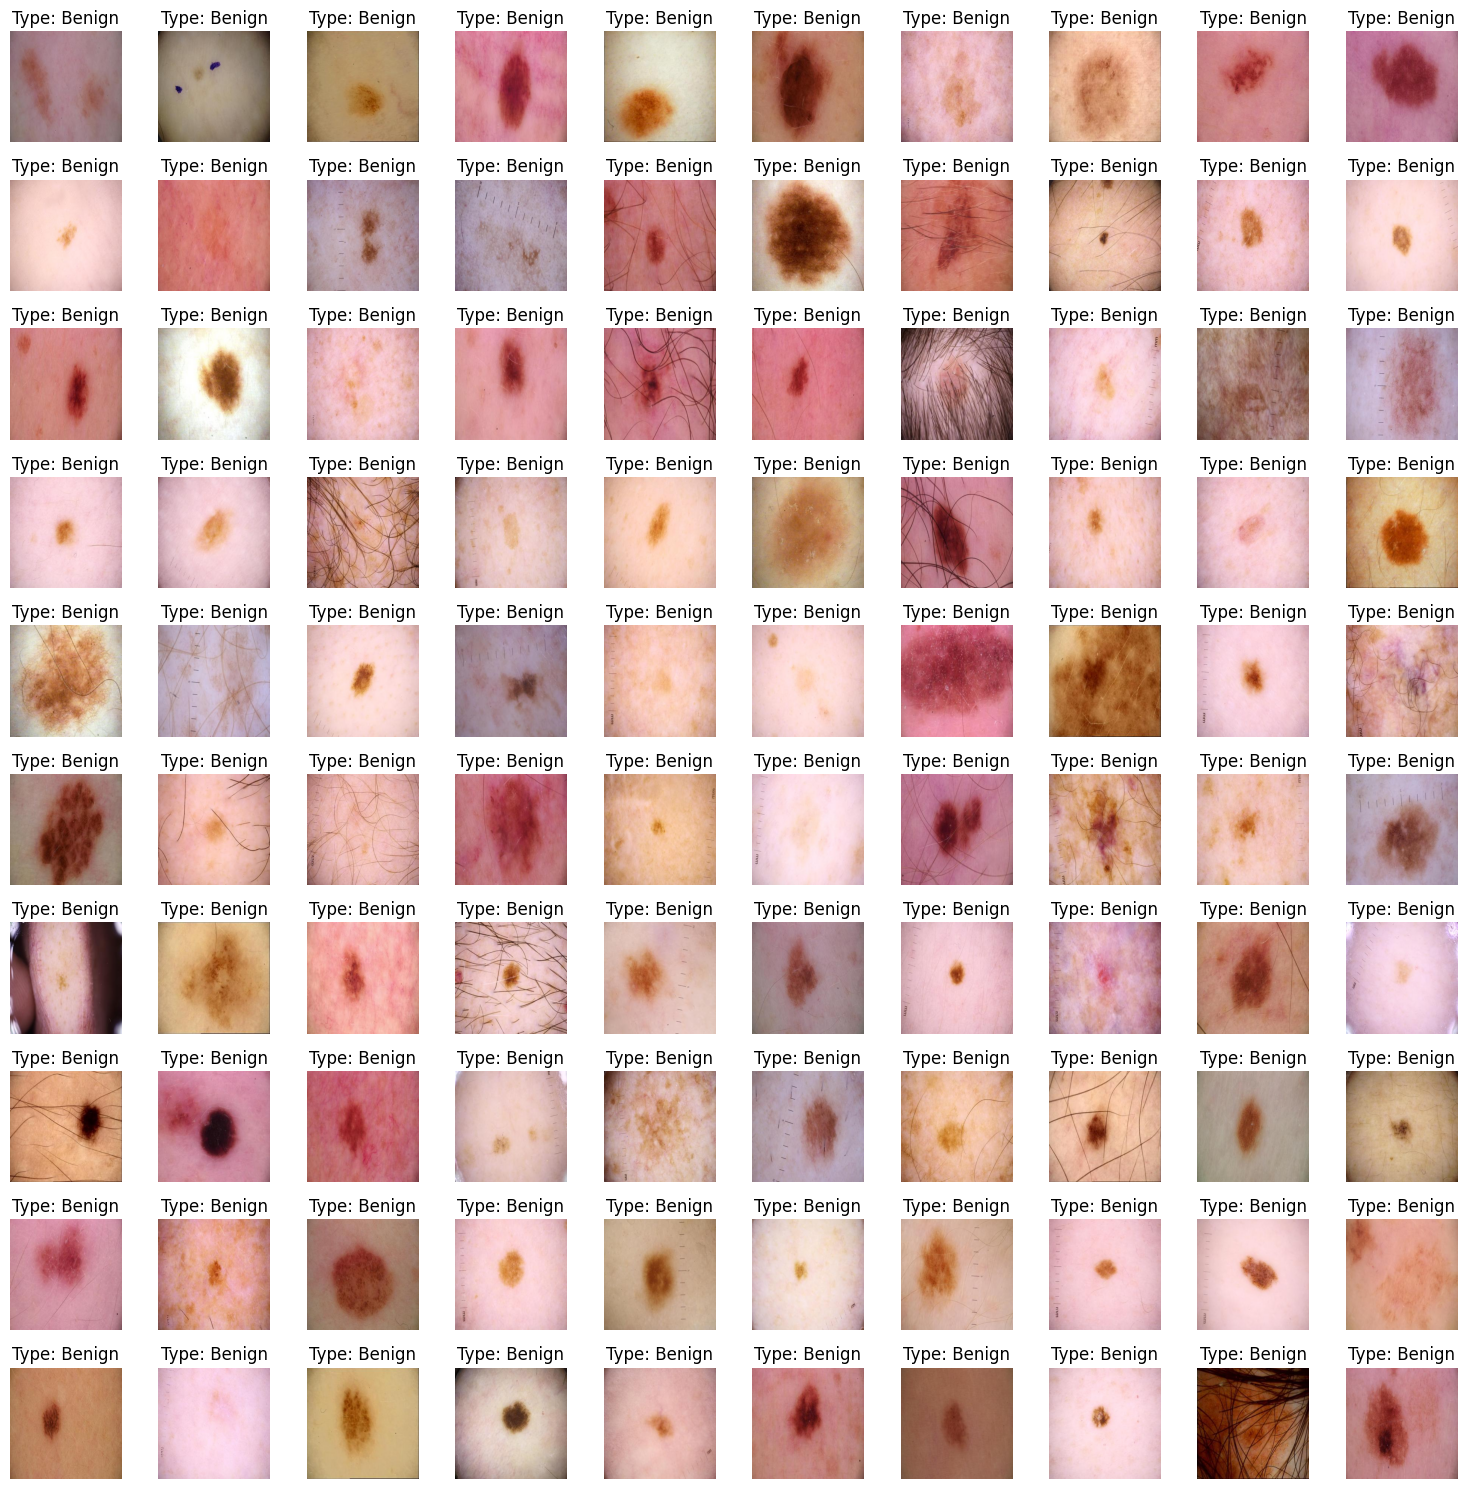

In [21]:
plot_image_grid(sample_df, image_column='Image Path', class_column='Neoplasm Type', grid_size=(10,10))

And we observe individually at a bigger image size some data from our stratified sample. We can already see that most of your data tends to be from subjects with lighter skin tones and a variety of shapes and textures of skin lesions attributed to melanoma.

Type: Benign


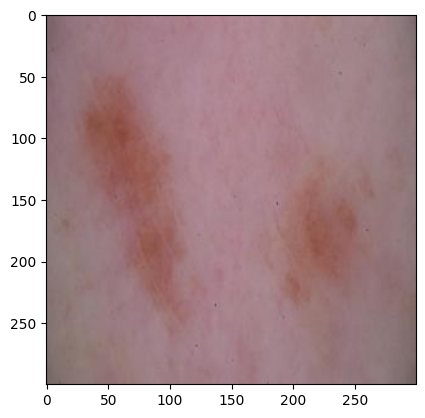

Type: Benign


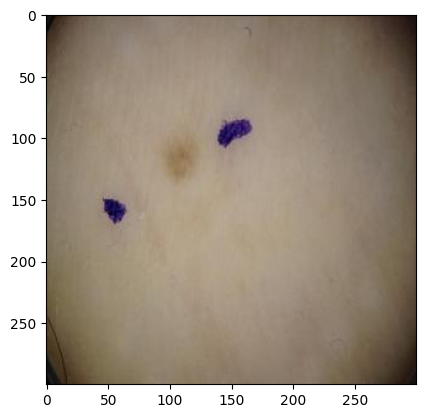

Type: Benign


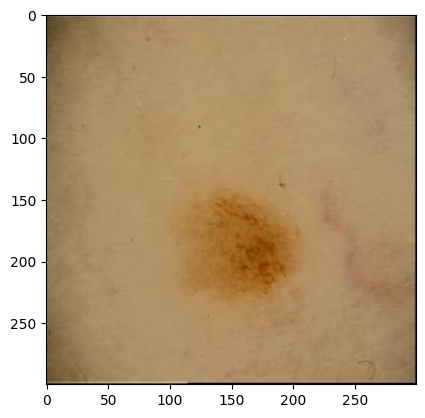

In [22]:
for i, data in enumerate(sample_df.values):
    if i >= 3:
        break

    path, label, target = data
    # # Read and resize the image
    img = cv.imread(path)
    
    if img is None:
        print(f"Error loading image at {path}")
        continue
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        
    # Plot the image
    print(f"Type: {label}")
    plt.imshow(img)
    plt.show()

### Class (Benign:Malignant, 0:1) Distribution

The class distribution of the training dataset before and after balancing is visualized

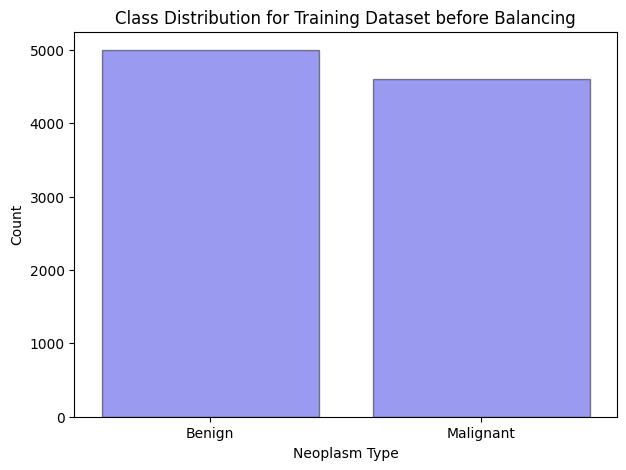

In [23]:
plt.figure(figsize=(7, 5))
sns.countplot(data=train_df, edgecolor='k', color='b', alpha=0.45, x='Neoplasm Type')
plt.title('Class Distribution for Training Dataset before Balancing')
plt.xlabel('Neoplasm Type')
plt.ylabel('Count')
plt.show()

We can see that there is a slight class imbalance, with more samples for `Benign` cases than for `Malignant`. Let's fix that!

In [24]:
sample_size = len(train_df)

# Calculate the number of unique classes
unique_classes = train_df['Neoplasm Type'].unique()
num_classes = len(unique_classes)
samples_per_class = sample_size // num_classes

# Collect stratified samples
stratified_sample = []
for cls in unique_classes:
    class_sample = train_df[train_df['Neoplasm Type'] == cls].sample(samples_per_class, random_state=42, replace=True)
    stratified_sample.append(class_sample)

# Combine the samples into a single DataFrame
train_df = pd.concat(stratified_sample).reset_index(drop=True)

# Check the distribution of the classes in the sample
print(train_df['Neoplasm Type'].value_counts())

Neoplasm Type
Benign       4802
Malignant    4802
Name: count, dtype: int64


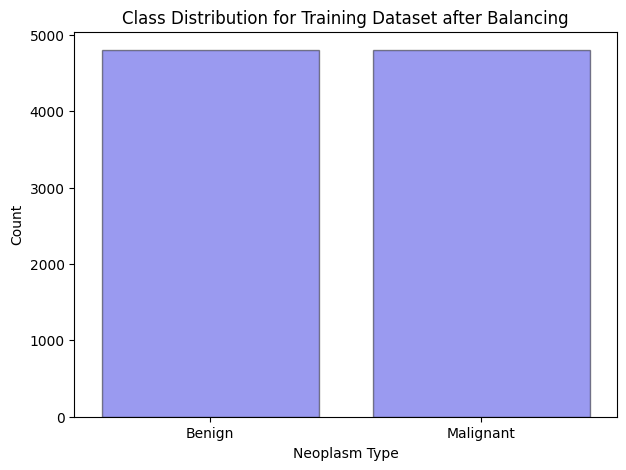

In [25]:
plt.figure(figsize=(7, 5))
sns.countplot(data=train_df, edgecolor='k', color='b', alpha=0.45, x='Neoplasm Type')
plt.title('Class Distribution for Training Dataset after Balancing')
plt.xlabel('Neoplasm Type')
plt.ylabel('Count')
plt.show()

Much better! Let's now see the class distribution for out `train_df` and our `test_df`.

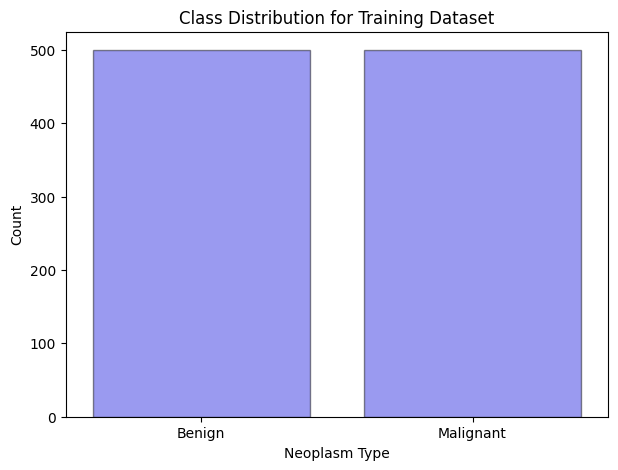

In [26]:
plt.figure(figsize=(7, 5))
sns.countplot(data=test_df, edgecolor='k', color='b', alpha=0.45, x='Neoplasm Type')
plt.title('Class Distribution for Training Dataset')
plt.xlabel('Neoplasm Type')
plt.ylabel('Count')
plt.show()

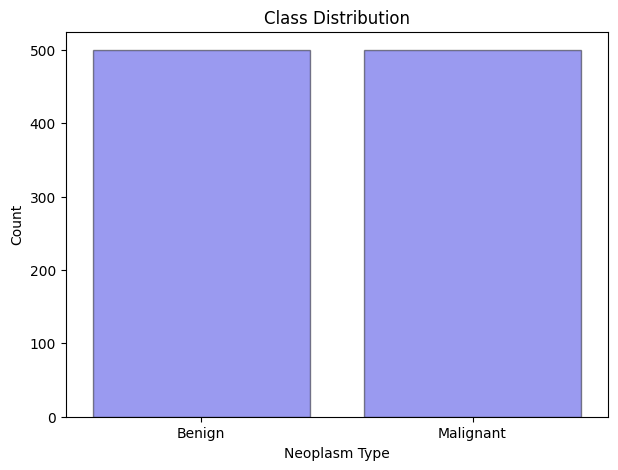

In [27]:
plt.figure(figsize=(7, 5))
sns.countplot(data=sample_df, edgecolor='k', color='b', alpha=0.45, x='Neoplasm Type')
plt.title('Class Distribution')
plt.xlabel('Neoplasm Type')
plt.ylabel('Count')
plt.show()

### Fetch image features and flatten into sample dataframe

We can see that our dataset has a fair and equal amount of data for both classes. Now let's see the pixel values that are extracted as features. We first wish to have our pixel values normalized (from `0 to 255` to `0.00 to 1.00` values), and add them to the sample DataFrame (`sample_df`):

In [28]:
sample_df = image_features(sample_df, image_column='Image Path')
display(sample_df)

,Image Path,Neoplasm Type,Target,0,1,2,3,4,5,6,...,269990,269991,269992,269993,269994,269995,269996,269997,269998,269999
0,../data/melanoma_cancer_dataset/train/benign/m...,Benign,0,0.466667,0.376471,0.400000,0.474510,0.384314,0.407843,0.482353,...,0.388235,0.443137,0.388235,0.384314,0.439216,0.384314,0.380392,0.435294,0.380392,0.376471
1,../data/melanoma_cancer_dataset/train/benign/m...,Benign,0,0.062745,0.090196,0.113725,0.043137,0.074510,0.086275,0.058824,...,0.058824,0.086275,0.066667,0.054902,0.078431,0.062745,0.058824,0.074510,0.058824,0.054902
2,../data/melanoma_cancer_dataset/train/benign/m...,Benign,0,0.223529,0.160784,0.109804,0.223529,0.160784,0.109804,0.223529,...,0.000000,0.027451,0.000000,0.000000,0.105882,0.070588,0.043137,0.023529,0.000000,0.000000
3,../data/melanoma_cancer_dataset/train/benign/m...,Benign,0,0.815686,0.478431,0.592157,0.815686,0.478431,0.592157,0.815686,...,0.356863,0.564706,0.352941,0.345098,0.545098,0.345098,0.333333,0.537255,0.337255,0.325490
4,../data/melanoma_cancer_dataset/train/benign/m...,Benign,0,0.521569,0.458824,0.368627,0.517647,0.454902,0.356863,0.529412,...,0.039216,0.168627,0.098039,0.019608,0.168627,0.086275,0.003922,0.168627,0.082353,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,../data/melanoma_cancer_dataset/train/malignan...,Malignant,1,0.015686,0.023529,0.019608,0.015686,0.023529,0.019608,0.015686,...,0.011765,0.007843,0.015686,0.011765,0.007843,0.015686,0.011765,0.007843,0.015686,0.011765
996,../data/melanoma_cancer_dataset/train/malignan...,Malignant,1,0.745098,0.462745,0.556863,0.745098,0.462745,0.556863,0.749020,...,0.443137,0.584314,0.388235,0.431373,0.564706,0.380392,0.419608,0.560784,0.376471,0.415686
997,../data/melanoma_cancer_dataset/train/malignan...,Malignant,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
998,../data/melanoma_cancer_dataset/train/malignan...,Malignant,1,0.466667,0.560784,0.654902,0.372549,0.458824,0.549020,0.458824,...,0.321569,0.137255,0.200000,0.290196,0.141176,0.207843,0.286275,0.360784,0.427451,0.505882


### Pixel Value Distribution

The distribution of pixel values across images in the sample dataset is visualized. We can see that most of our pixel values are between the `0.6` to `0.8` range. This is consistent with what our data looks like, that being that our subject have lighter complexion thus their respective pixel values are higher. Moreover, we can see a large set of pixel values in the `0.0` range. Another consistent finding since there are dermatoscopic images with a black mask surrounding the skin lesion.

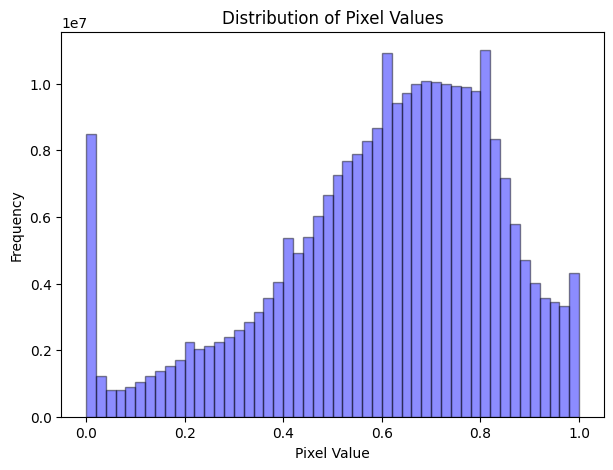

In [29]:
pixel_columns = sample_df.columns[3:]
pixel_values = sample_df[pixel_columns].values

plt.figure(figsize=(7, 5))
plt.hist(pixel_values.flatten(), edgecolor='k', color='b', alpha=0.45, bins=50)
# sns.histplot(pixel_values.flatten(), bins=50, kde=True)
plt.title('Distribution of Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

Descriptive statistics such as mean, median, and standard deviation of pixel values are computed and visualized:

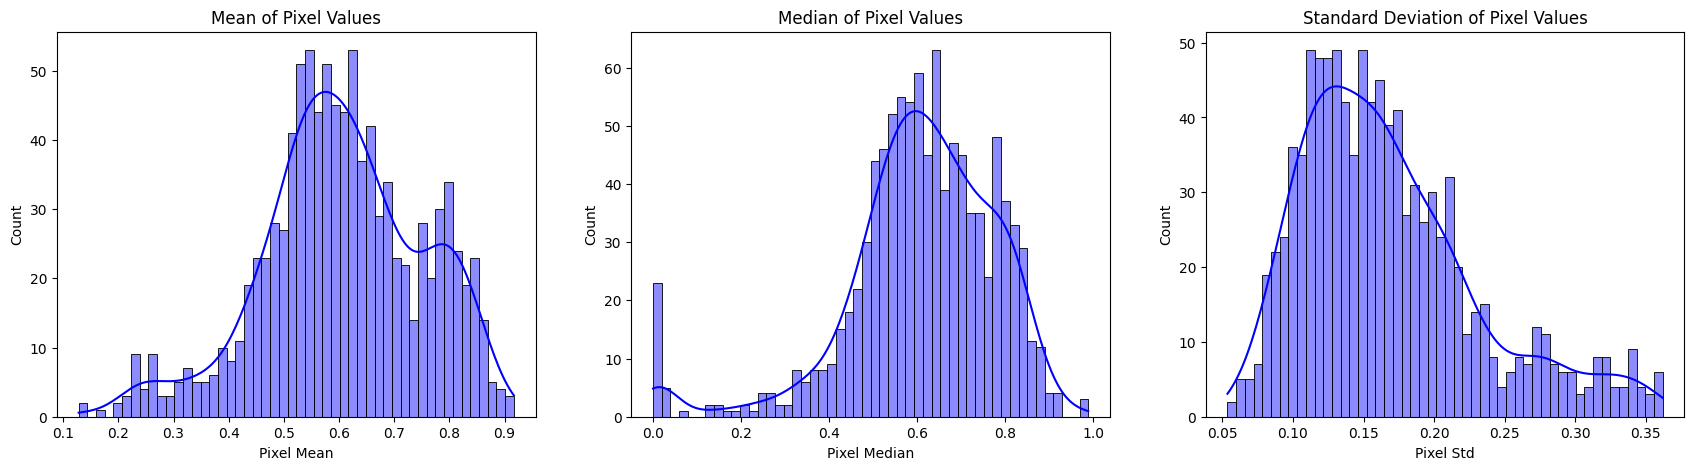

In [30]:
descriptive_stats_df = pd.DataFrame([])
pixel_mean = np.mean(pixel_values, axis=1)
pixel_median = np.median(pixel_values, axis=1)
pixel_std = np.std(pixel_values, axis=1)

descriptive_stats_df['Pixel Mean'] = pixel_mean
descriptive_stats_df['Pixel Median'] = pixel_median
descriptive_stats_df['Pixel Std'] = pixel_std

plt.figure(figsize=(21, 5))
plt.subplot(1, 3, 1)
sns.histplot(descriptive_stats_df['Pixel Mean'], bins=50, color='b', alpha=0.45, kde=True)
plt.title('Mean of Pixel Values')

plt.subplot(1, 3, 2)
sns.histplot(descriptive_stats_df['Pixel Median'], bins=50, color='b', alpha=0.45, kde=True)
plt.title('Median of Pixel Values')

plt.subplot(1, 3, 3)
sns.histplot(descriptive_stats_df['Pixel Std'], bins=50, color='b', alpha=0.45, kde=True)
plt.title('Standard Deviation of Pixel Values')

plt.show()

In [31]:
mean = np.mean(pixel_values)
std = np.std(pixel_values)

print("Pixel Value Mean:", round(mean, 4), "Pixel Value Std:", round(std, 4))

Pixel Value Mean: 0.6049 Pixel Value Std: 0.2308


### Generate Mask for Image with Lesion Outlines

A mask showing lesion outlines is generated and displayed for a sample image. We try to create a mask to see how complex is the task of identifing a region of interest that could potential be a melanoma that is benign or malignant. This an important task to accomplish and relevant in the future as we want to build a segmentation model that can appropriately idenfity the skin lesion and if it is cancerous or not.

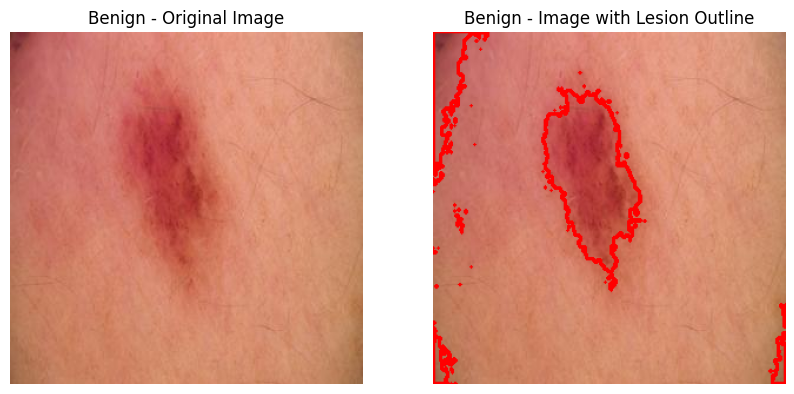

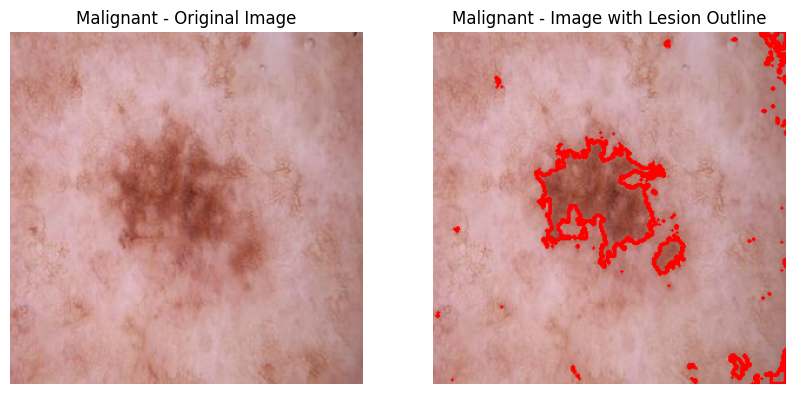

In [36]:
generate_mask(sample_df)  # Use image path
generate_mask(sample_df)  # Use pixel columns